In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

In [2]:
train_folder_path = "./data/X_train/"
test_folder_path = "./data/X_test/"

# Clinical Data
df = pd.read_csv(train_folder_path + "clinical_train.csv", sep=",")
df_eval = pd.read_csv(test_folder_path + "clinical_test.csv", sep=",")

# Molecular Data
maf_df = pd.read_csv(train_folder_path + "molecular_train.csv", sep=",")
maf_eval = pd.read_csv(test_folder_path + "molecular_test.csv", sep=",")

target_df = pd.read_csv(train_folder_path + "target_train.csv", sep=",")
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
#target_df_test = pd.read_csv("./data/target_test.csv")

# Preview the data
target_df.head()

,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,True
1,P132698,4.928767,False
2,P116889,2.043836,False
3,P132699,2.476712,True
4,P132700,3.145205,False


### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [3]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

OS_STATUS       bool
OS_YEARS     float64
dtype: object


### Step 2: Exploring the Data

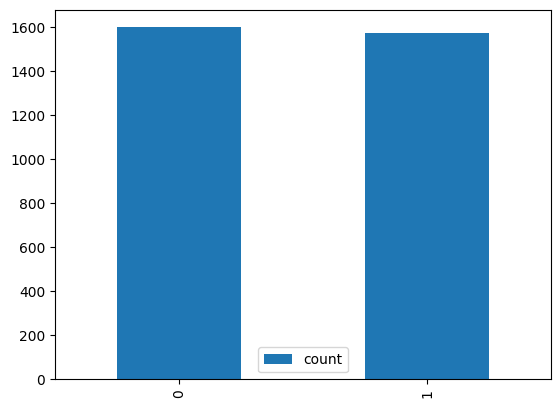

In [4]:
x = target_df["OS_STATUS"].value_counts().reset_index()
x.plot.bar()
plt.show()

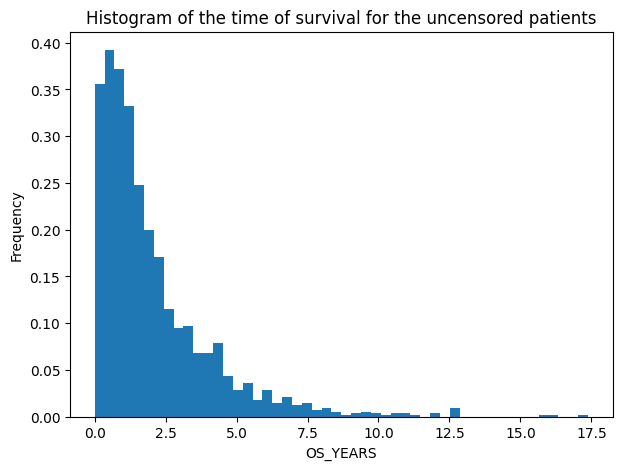

In [5]:
x = target_df.loc[target_df["OS_STATUS"] == True]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the uncensored patients')
plt.show()


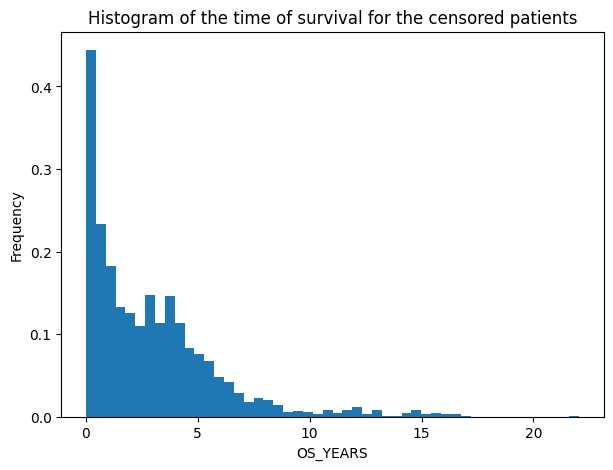

In [6]:
x = target_df.loc[target_df["OS_STATUS"] == False]["OS_YEARS"]
plt.figure(figsize=(7, 5))
plt.hist(x, bins=50, density=True)
plt.xlabel('OS_YEARS')
plt.ylabel('Frequency')
plt.title('Histogram of the time of survival for the censored patients')
plt.show()

On s'intéresse au statut des gens ayant des informations Cytogénétiques sans anomalies

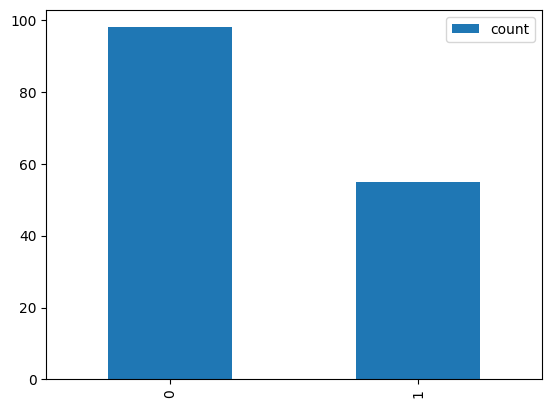

In [22]:
nf = df.loc[df["CYTOGENETICS"] == "46,xx"]
nm = df.loc[df["CYTOGENETICS"] == "46,xy"]
pd.concat([nf, nm])
nf_target = target_df.loc[target_df["ID"].isin(nf["ID"])]
nf_target["OS_STATUS"].value_counts().reset_index().plot.bar()
plt.show()

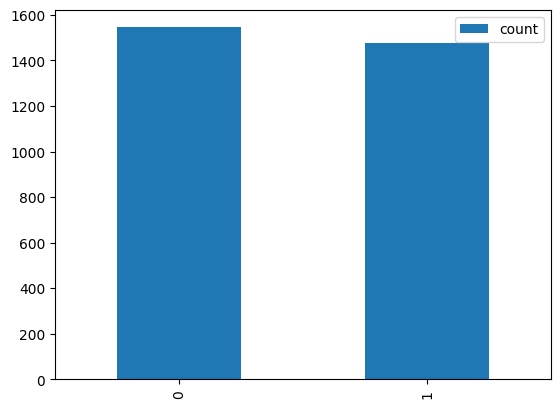

In [23]:
nf = df.loc[df["CYTOGENETICS"] != "46,xx"]
nm = df.loc[df["CYTOGENETICS"] != "46,xy"]
pd.concat([nf, nm])
nf_target = target_df.loc[target_df["ID"].isin(nf["ID"])]
nf_target["OS_STATUS"].value_counts().reset_index().plot.bar()
plt.show()

### Gene analysis

On cherche à présent à visualiser la répartition des gènes au sein de l'ensemble des patients

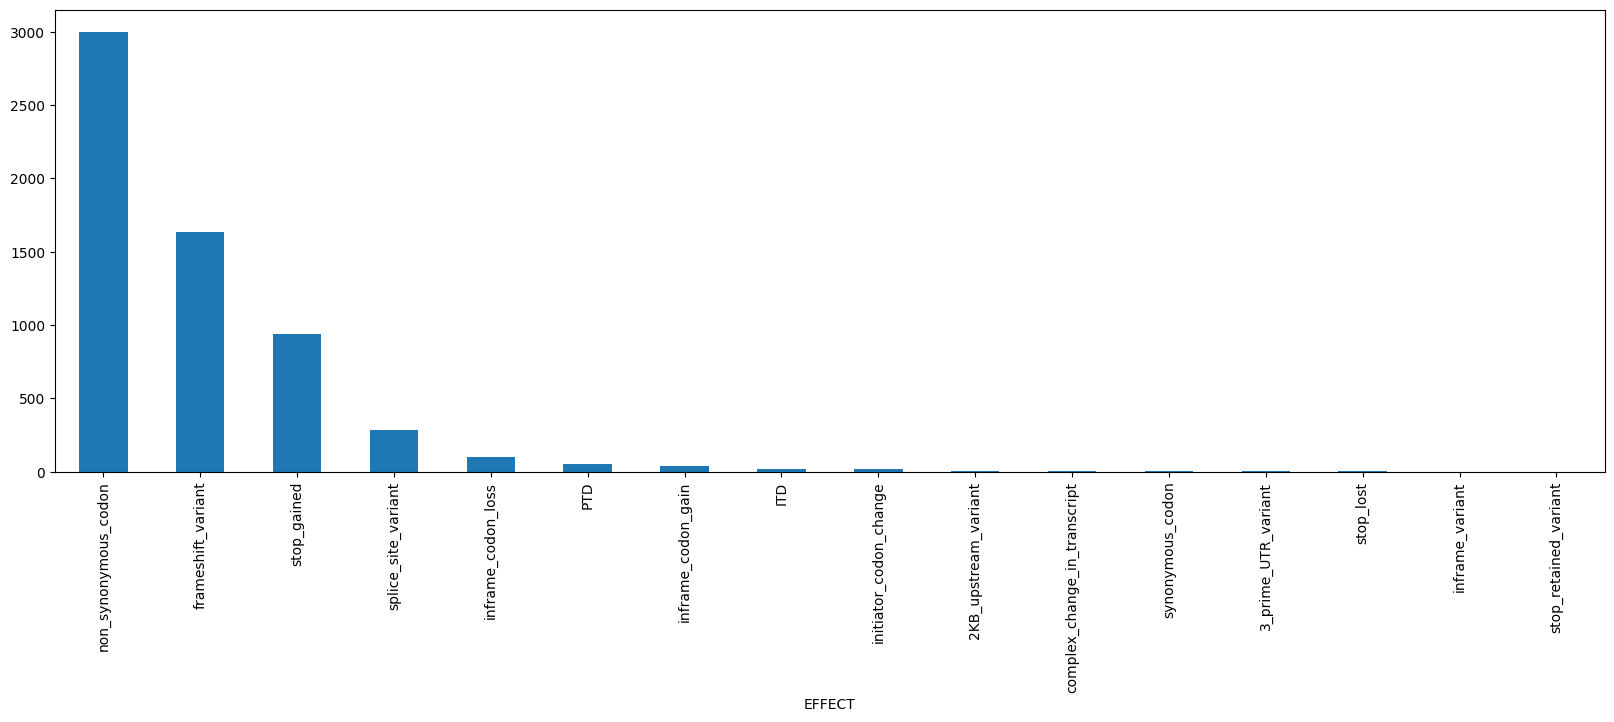

In [24]:
new_df = target_df.merge(maf_df, how="left", on="ID")
plt.figure(figsize=(20, 6))
x = new_df.loc[new_df["OS_STATUS"] == True]["EFFECT"].value_counts().plot(kind="bar", rot=45)
plt.xticks(rotation=90)
plt.show()

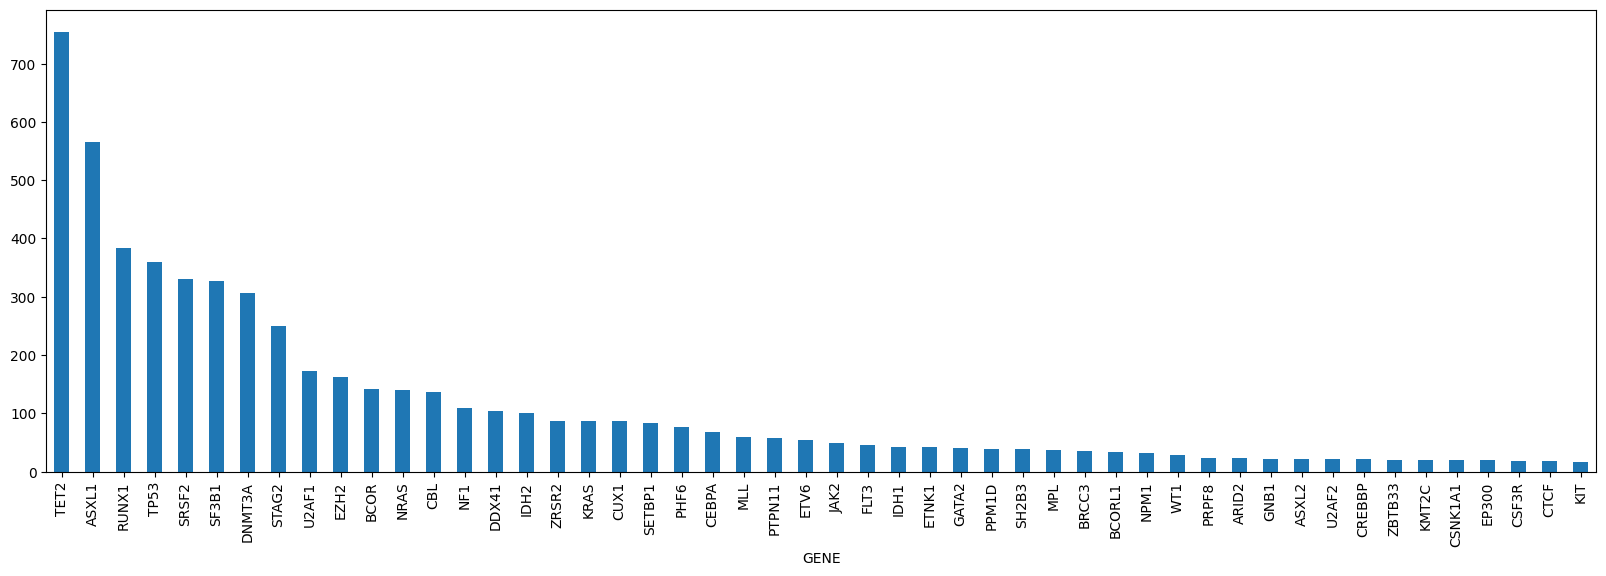

In [ ]:
#Répartition des gènes pour les patients non-censurés
new_df = target_df.merge(maf_df, how="left", on="ID")
plt.figure(figsize=(20, 6))
x = new_df.loc[new_df["OS_STATUS"] == True]["GENE"].value_counts()[:50].plot(kind="bar", rot=45)
plt.xticks(rotation=90)
plt.show()

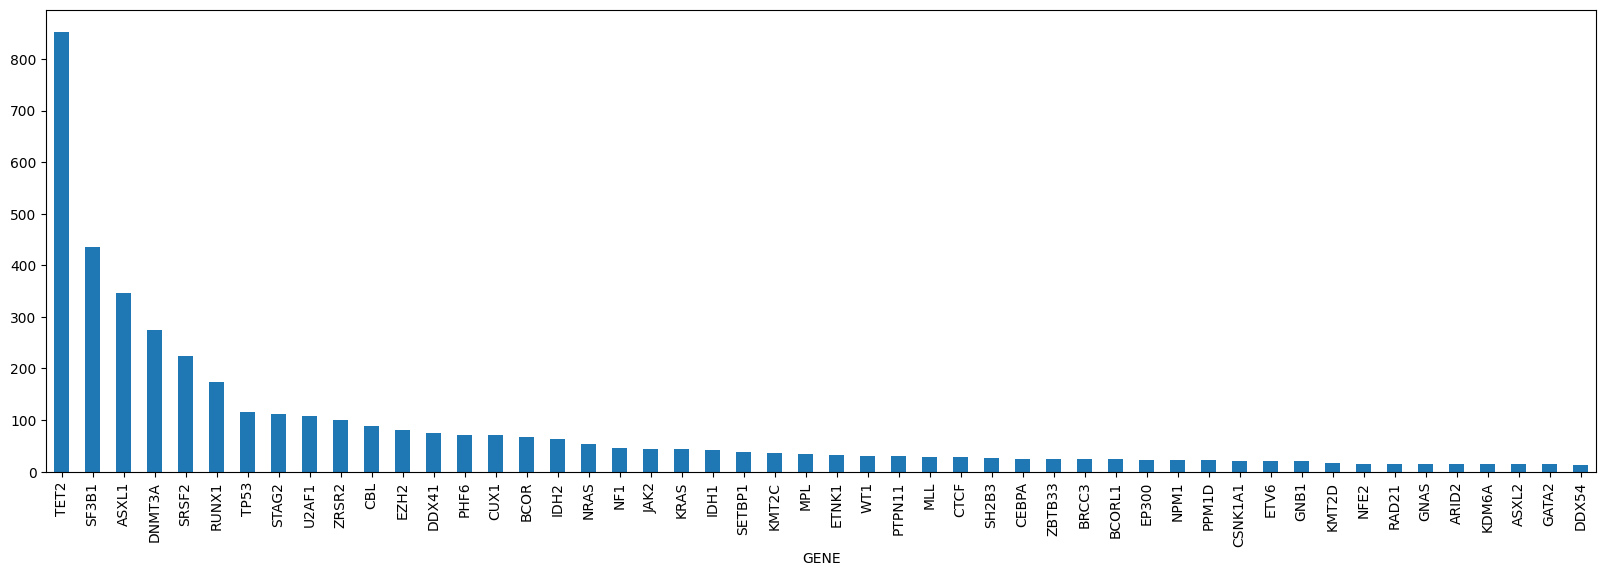

In [ ]:
#Répartition des gènes pour les patients censurés
new_df = target_df.merge(maf_df, how="left", on="ID")
plt.figure(figsize=(20, 6))
x = new_df.loc[new_df["OS_STATUS"] == False]["GENE"].value_counts()[:50].plot(kind="bar", rot=45)
plt.xticks(rotation=90)
plt.show()

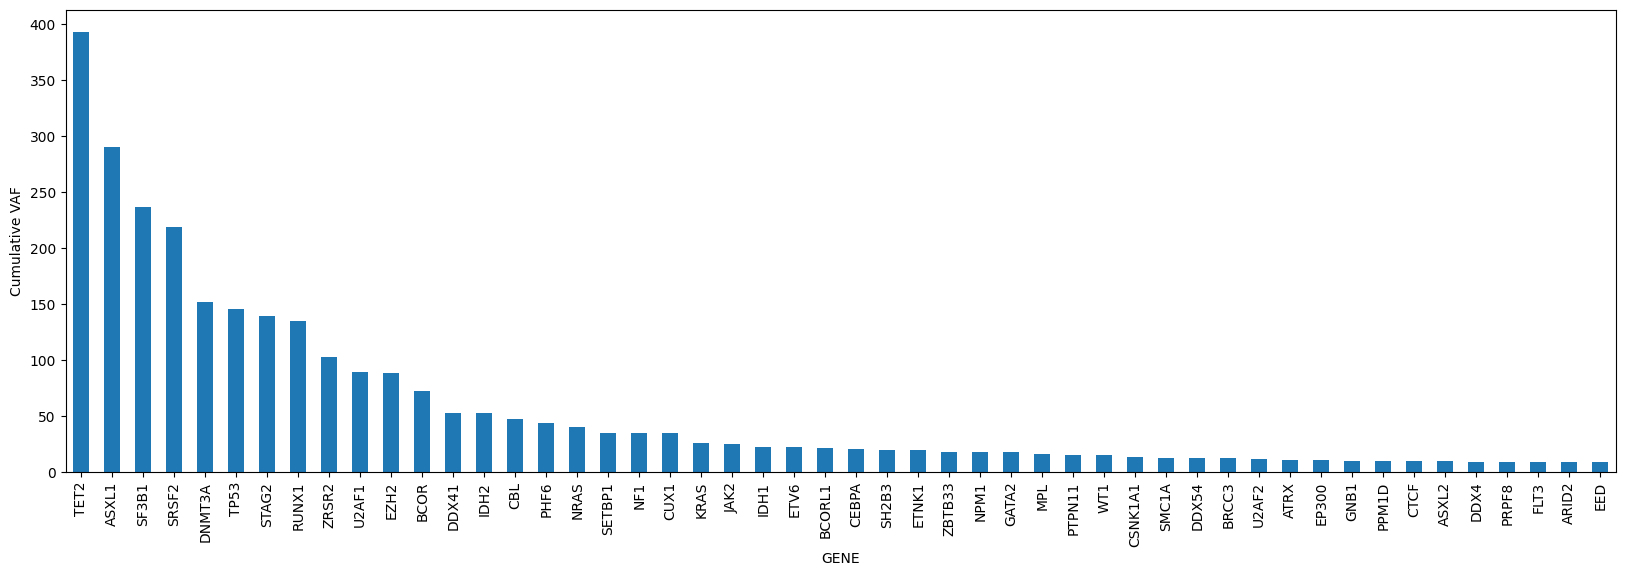

In [ ]:
#Histogramme des valeurs de vaf cumulatives par gèes pour l'ensemble des patients
maf_df_copy = maf_df.copy()
maf_df_copy["VAF"] = pd.to_numeric(maf_df_copy["VAF"], errors="coerce")
maf_df_copy["ID"] = maf_df_copy["ID"].astype(str)
maf_df_copy["GENE"] = maf_df_copy["GENE"].astype(str)
gene_matrix = (
    maf_df_copy
    .groupby(["ID", "GENE"])["VAF"]
    .max()                          
    .unstack(fill_value=0)          
    .reset_index()
)

x = gene_matrix.drop("ID", axis=1)
plt.figure(figsize=(20, 6))
x.sum().sort_values(ascending=False)[:50].plot.bar()
plt.ylabel("Cumulative VAF")
plt.show()

### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT']])
X_test[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT']])

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [32]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.65


### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.

In [33]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.

In [34]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [35]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT', 'Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']])
X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

In [38]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.4f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.4f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.6843
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.6830


### Step 6: Find other features to improve the prediction

Now we will try searching the best features to put in our predictors

### Compute Weighted Mutation Burden per Patient

In this step, we create a new feature called **`Nmut_2`**, representing a *weighted mutation burden* for each patient.  
Instead of simply counting the number of mutations, we account for the **variant allele frequency (VAF)**.

#### Formula

For each mutation *i* in patient *j*:


$$
\text{Nmut\_2}_j \;=\; \sum_{i \in \text{mutations of patient } j} \text{VAF}_{i,j}
$$


In [39]:
# Step 1: Compute weighted mutation burden per patient
tmp = (
    maf_df
    .assign(weighted_effect = maf_df["VAF"])
    .groupby("ID", as_index=False)["weighted_effect"]
    .sum()
    .rename(columns={"weighted_effect": "Nmut_2"})
)

# Step 2: Merge with the clinical dataset
df_3 = (
    df_2
    .merge(tmp, on="ID", how="left")
    .fillna({"Nmut_2": 0})  # patients with no mutations get Nmut = 0
)

df_3.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,Nmut,Nmut_2
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",9.0,2.2642
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",3.0,0.8186
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",3.0,0.1180
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",11.0,2.3015
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",1.0,0.4721


In [41]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

results = []

# Merge with the clinical and molecular training dataset 
all_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_2']
base_model = CoxnetSurvivalAnalysis()

for k in range(1, 9):
    for subset in combinations(all_features, k):
        subset = list(subset)

        # Select features and target
        X = df_3.loc[df_3['ID'].isin(target_df["ID"]), subset].copy()
        y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

        # Handle missing values
        imputer = SimpleImputer(strategy="median")
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=subset)

        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y, test_size=0.3, random_state=42
        )

        # Fit Cox model
        model = base_model.fit(X_train, y_train)

        # Predict risk scores
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # Compute Concordance Index IPCW
        train_ci = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
        test_ci = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]

        # Store results
        results.append({
            "Features": subset,
            "Train C-index": train_ci,
            "Test C-index": test_ci
        })

# ===============================================================
# Display Results
# ===============================================================

results_df = (
    pd.DataFrame(results)
    .sort_values(by="Test C-index", ascending=False)
    .reset_index(drop=True)
)

print("✅ Top-performing feature subsets:")
display(results_df.head(10))

✅ Top-performing feature subsets:


,Features,Train C-index,Test C-index
0,"[BM_BLAST, HB, PLT, WBC, MONOCYTES, Nmut]",0.685726,0.685607
1,"[BM_BLAST, HB, PLT, WBC, ANC, MONOCYTES, Nmut]",0.685784,0.685560
2,"[BM_BLAST, HB, PLT, WBC, Nmut]",0.685677,0.685363
3,"[BM_BLAST, HB, PLT, WBC, ANC, Nmut]",0.685745,0.685324
4,"[BM_BLAST, HB, PLT, ANC, MONOCYTES, Nmut]",0.686327,0.685300
5,"[BM_BLAST, HB, PLT, ANC, Nmut]",0.686334,0.685294
6,"[BM_BLAST, HB, PLT, MONOCYTES, Nmut]",0.684962,0.683756
7,"[BM_BLAST, HB, PLT, Nmut]",0.684431,0.683280
8,"[BM_BLAST, HB, PLT, WBC, ANC, MONOCYTES, Nmut,...",0.689877,0.682413
9,"[BM_BLAST, HB, PLT, WBC, Nmut, Nmut_2]",0.690005,0.682384


#### Conclusion
Nmut appears to work better than Nmut2


### Weighted Mutation Burden 

In order to quantify the mutation burden for each patient, we compute a **weighted mutation score**, `Nmut_4`. This score captures both the **location of the mutation** (chromosomal start position) and its **variant allele fraction (VAF)**, providing a more nuanced representation than a simple mutation count.

#### Formula

For each mutation *i* in patient *j*:


$$
\text{Nmut\_2}_j \;=\; \sum_{i \in \text{mutations of patient } j} \frac{\text{START}_{i,j} \times \text{VAF}_{i,j}}{n \times 1e6}
$$


In [42]:
maf_df_copy = maf_df.copy()

# Show unique chromosome identifiers
chr_map = {**{str(i): i for i in range(1, 23)}, "X": 23, "Y": 24, "MT": 25}
maf_df_copy["CHR"] = maf_df_copy["CHR"].map(chr_map)
maf_df_copy["CHR"].astype(float)
maf_df_copy["CHR"] = maf_df_copy["CHR"].fillna(0)
maf_df_copy["CHR"].unique()

array([11.,  5.,  3.,  4.,  2., 22., 17., 23., 12.,  9.,  7.,  1.,  8.,
       16., 20., 21., 19., 15., 13.,  6., 18., 14., 10.,  0.])

In [43]:
# Step 1: Compute weighted mutation burden per patient
tmp = (
    maf_df_copy
    .assign(weighted_effect = maf_df_copy["START"] * maf_df_copy["VAF"] / 1e6) #
    .groupby("ID", as_index=False)["weighted_effect"]
    .mean()
    .rename(columns={"weighted_effect": "Nmut_4"})
)

# Step 2: Merge with the clinical dataset
df_5 = (
    df_2
    .merge(tmp, on="ID", how="left")
    .fillna({"Nmut_4": 0})  # patients with no mutations get Nmut = 0
)

df_5.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,Nmut,Nmut_4
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",9.0,11.503142
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",3.0,6.470014
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",3.0,5.283016
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",11.0,13.988418
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",1.0,14.645694


In [44]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

results = []

# Merge with the clinical and molecular training dataset 
all_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4']
base_model = CoxnetSurvivalAnalysis()

for k in range(1, 9):
    for subset in combinations(all_features, k):
        subset = list(subset)

        # Select features and target
        X = df_5.loc[df_5['ID'].isin(target_df["ID"]), subset].copy()
        y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

        # Handle missing values
        imputer = SimpleImputer(strategy="median")
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=subset)

        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y, test_size=0.3, random_state=42
        )

        # Fit Cox model
        model = base_model.fit(X_train, y_train)

        # Predict risk scores
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # Compute Concordance Index IPCW
        train_ci = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
        test_ci = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]

        # Store results
        results.append({
            "Features": subset,
            "Train C-index": train_ci,
            "Test C-index": test_ci
        })

# ===============================================================
# Display Results
# ===============================================================

results_df = (
    pd.DataFrame(results)
    .sort_values(by="Test C-index", ascending=False)
    .reset_index(drop=True)
)

print("✅ Top-performing feature subsets:")
display(results_df.head(10))
print(results_df.iloc[0]["Features"])

✅ Top-performing feature subsets:


,Features,Train C-index,Test C-index
0,"[BM_BLAST, HB, PLT, WBC, ANC, MONOCYTES, Nmut,...",0.686608,0.688707
1,"[BM_BLAST, HB, PLT, WBC, MONOCYTES, Nmut, Nmut_4]",0.686477,0.688682
2,"[BM_BLAST, HB, PLT, WBC, ANC, Nmut, Nmut_4]",0.686608,0.688602
3,"[BM_BLAST, HB, PLT, WBC, Nmut, Nmut_4]",0.686516,0.688503
4,"[BM_BLAST, HB, PLT, ANC, Nmut, Nmut_4]",0.687191,0.687898
5,"[BM_BLAST, HB, PLT, ANC, MONOCYTES, Nmut, Nmut_4]",0.687184,0.687897
6,"[BM_BLAST, HB, PLT, MONOCYTES, Nmut, Nmut_4]",0.685874,0.686591
7,"[BM_BLAST, HB, PLT, Nmut, Nmut_4]",0.685297,0.686219
8,"[BM_BLAST, HB, PLT, WBC, MONOCYTES, Nmut]",0.685726,0.685607
9,"[BM_BLAST, HB, PLT, WBC, ANC, MONOCYTES, Nmut]",0.685784,0.685560


['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4']


### Gene Mutations

We aimed to identify the mutated genes that most significantly influence our survival predictions.
To achieve this, we quantified the mutational impact of each gene by assigning, for every patient, the maximum Variant Allele Frequency (VAF) observed across all mutations occurring within that gene.
If a given gene was not mutated in a patient, a value of zero was assigned to ensure consistent representation across all individuals.

In [45]:
# Make a copy of your mutation dataframe
maf_df_copy = maf_df.copy()

# Ensure proper datatypes
maf_df_copy["VAF"] = pd.to_numeric(maf_df_copy["VAF"], errors="coerce")
maf_df_copy["ID"] = maf_df_copy["ID"].astype(str)
maf_df_copy["GENE"] = maf_df_copy["GENE"].astype(str)

# Step 1️⃣: Pivot to create a matrix of patients (rows) × genes (columns)
# If a patient has multiple mutations in the same gene, take the max VAF
gene_matrix = (
    maf_df_copy
    .groupby(["ID", "GENE"])["VAF"]
    .max()                          # use max VAF per gene per patient
    .unstack(fill_value=0)          # convert to wide format
    .reset_index()
)

# Step 2️⃣: Merge with your clinical dataframe
df_with_genes = df_5.merge(gene_matrix, on="ID", how="left")

# Step 3️⃣: Replace missing values (patients without a given gene mutation)
df_with_genes = df_with_genes.fillna(0)

# ✅ Now df_with_genes has one column per gene (e.g. TP53, TET2, DNMT3A, etc.)
# Each value = VAF if mutated, or 0 if not mutated
print(df_with_genes.shape)
#df_with_genes.head()
df_with_genes.iloc[:, 9:].head()

(3323, 135)


,Nmut,Nmut_4,ABL1,ARID1A,ARID2,ASXL1,ASXL2,ATRX,BAP1,BCL10,...,TET2,TP53,U2AF1,U2AF2,WHSC1,WT1,ZBTB33,ZMYM3,ZNF318,ZRSR2
0,9.0,11.503142,0.0,0.0,0.0000,0.3553,0.0,0.0,0.0,0.0,...,0.394,0.0,0.35,0.0,0.0,0.000,0.0,0.0,0.0,0.000
1,3.0,6.470014,0.0,0.0,0.0000,0.2825,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2,3.0,5.283016,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.035,0.0,0.0,0.0,0.000
3,11.0,13.988418,0.0,0.0,0.0984,0.2871,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.049
4,1.0,14.645694,0.0,0.0,0.0000,0.4721,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000


In [46]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

results = []

# Merge with the clinical and molecular training dataset 
fixed_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4', 'TP53','TET2','SF3B1','CBL']
#fixed_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53','TET2','SF3B1','CBL']
features_choose = df_with_genes.columns[10:].tolist()
base_model = CoxnetSurvivalAnalysis()

for k in range(1, 2):
    for subset in combinations(features_choose, k):
        subset = list(subset)
        selected_features = list(set(fixed_features + subset))

        # Select features and target
        X = df_with_genes.loc[df_with_genes['ID'].isin(target_df["ID"]), selected_features].copy()
        y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

        # Handle missing values
        imputer = SimpleImputer(strategy="median")
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=selected_features)

        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y, test_size=0.3, random_state=42
        )

        # Fit Cox model
        model = base_model.fit(X_train, y_train)

        # Predict risk scores
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # Compute Concordance Index IPCW
        train_ci = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
        test_ci = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]

        # Store results
        results.append({
            "Features": subset,
            "Train C-index": train_ci,
            "Test C-index": test_ci
        })

# ===============================================================
# Display Results
# ===============================================================

results_df = (
    pd.DataFrame(results)
    .sort_values(by="Test C-index", ascending=False)
    .reset_index(drop=True)
)

print("✅ Top-performing feature subsets:")
display(results_df.head(10))

✅ Top-performing feature subsets:


,Features,Train C-index,Test C-index
0,[EZH2],0.701791,0.704693
1,[Nmut_4],0.699887,0.704594
2,[RB1],0.699887,0.704594
3,[RAD21],0.699887,0.704594
4,[RAC1],0.699887,0.704594
5,[PTPRF],0.699887,0.704594
6,[PTPN11],0.699887,0.704594
7,[PTEN],0.699887,0.704594
8,[PRPF8],0.699887,0.704594
9,[PRPF40A],0.699887,0.704594


In [47]:
# Make a copy of your mutation dataframe
maf_df_copy = maf_df.copy()

# Ensure proper datatypes
maf_df_copy["VAF"] = pd.to_numeric(maf_df_copy["VAF"], errors="coerce")
maf_df_copy["ID"] = maf_df_copy["ID"].astype(str)
maf_df_copy["GENE"] = maf_df_copy["GENE"].astype(str)

# Step 1️⃣: Pivot to create a matrix of patients (rows) × genes (columns)
# If a patient has multiple mutations in the same gene, take the max VAF
gene_matrix = (
    maf_df_copy
    .groupby(["ID", "GENE"])["VAF"]
    .sum()                          # sum all VAF per gene per patient
    .unstack(fill_value=0)          # convert to wide format
    .reset_index()
)

# Step 2️⃣: Merge with your clinical dataframe
df_with_genes_sum = df_5.merge(gene_matrix, on="ID", how="left")

# Step 3️⃣: Replace missing values (patients without a given gene mutation)
df_with_genes_sum = df_with_genes_sum.fillna(0)

# ✅ Now df_with_genes has one column per gene (e.g. TP53, TET2, DNMT3A, etc.)
# Each value = VAF if mutated, or 0 if not mutated
print(df_with_genes_sum.shape)
#df_with_genes.head()
df_with_genes_sum.iloc[:, 9:].head()

(3323, 135)


,Nmut,Nmut_4,ABL1,ARID1A,ARID2,ASXL1,ASXL2,ATRX,BAP1,BCL10,...,TET2,TP53,U2AF1,U2AF2,WHSC1,WT1,ZBTB33,ZMYM3,ZNF318,ZRSR2
0,9.0,11.503142,0.0,0.0,0.0000,0.3553,0.0,0.0,0.0,0.0,...,0.394,0.0,0.35,0.0,0.0,0.000,0.0,0.0,0.0,0.000
1,3.0,6.470014,0.0,0.0,0.0000,0.2825,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2,3.0,5.283016,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.035,0.0,0.0,0.0,0.000
3,11.0,13.988418,0.0,0.0,0.0984,0.2871,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.049
4,1.0,14.645694,0.0,0.0,0.0000,0.4721,0.0,0.0,0.0,0.0,...,0.000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000


In [48]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

results = []

# Merge with the clinical and molecular training dataset 
# fixed_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4',
#                   'TP53','TET2','CBL', 'EZH2', 'ZRSR2', 'U2AF1', 'RUNX1', 'SF3B1','DNMT3A']
fixed_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES']#, 'Nmut']#,'TP53','TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']#,
                  #'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
features_choose = df_with_genes_sum.columns[10:].tolist()
base_model = CoxnetSurvivalAnalysis()

for k in range(1, 2):
    for subset in combinations(features_choose, k):
        subset = list(subset)
        selected_features = list(set(fixed_features + subset))

        # Select features and target
        X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), selected_features].copy()
        y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

        # Handle missing values
        imputer = SimpleImputer(strategy="median")
        X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=selected_features)

        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_imputed, y, test_size=0.3, random_state=42
        )

        # Fit Cox model
        model = base_model.fit(X_train, y_train)

        # Predict risk scores
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        # Compute Concordance Index IPCW
        train_ci = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
        test_ci = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]

        # Store results
        results.append({
            "Features": subset,
            "Train C-index": train_ci,
            "Test C-index": test_ci
        })

# ===============================================================
# Display Results
# ===============================================================

results_df = (
    pd.DataFrame(results)
    .sort_values(by="Test C-index", ascending=False)
    .reset_index(drop=True)
)

print("✅ Top-performing feature subsets:")
display(results_df.head(10))

✅ Top-performing feature subsets:


,Features,Train C-index,Test C-index
0,[TP53],0.676589,0.674229
1,[Nmut_4],0.657518,0.662065
2,[PAPD5],0.658302,0.660221
3,[RB1],0.658302,0.660221
4,[RAD50],0.658302,0.660221
5,[RAD21],0.658302,0.660221
6,[RAC1],0.658302,0.660221
7,[PTPRF],0.658302,0.660221
8,[PTPN11],0.658302,0.660221
9,[PTEN],0.658302,0.660221


#### Test on the whole mutation dataset

In [49]:
fixed_features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut']
molecular_features = df_with_genes_sum.columns[10:].tolist()  
selected_features = list(set(fixed_features + molecular_features))

# Select features and target
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), selected_features].copy()
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Handle missing values
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=selected_features)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# Fit Cox model
model = base_model.fit(X_train, y_train)

# Predict risk scores
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Compute Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]

print(f"COX Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.4f}")
print(f"COX Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.4f}")

COX Survival Model Concordance Index IPCW on train: 0.7075
COX Survival Model Concordance Index IPCW on test: 0.7053


### Step 7: Hyperparameter Tuning

In [50]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored


# features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4',
#                   'TP53','TET2','CBL', 'EZH2', 'ZRSR2', 'U2AF1', 'RUNX1', 'SF3B1','DNMT3A']
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53',
                  'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

def c_index_scorer(estimator, X, y):
    """Compute C-index (higher = better) for survival data in GridSearchCV."""
    risk_scores = estimator.predict(X)
    # Access fields of the structured array (not DataFrame)
    event = y["OS_STATUS"]
    time = y["OS_YEARS"]
    result = concordance_index_censored(event, time, risk_scores)
    return result[0]  # Concordance index

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

start = time()

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {'normalize': [True, False],
                    'tol': [1e-10, 1e-9, 1e-7, 1e-5, 1e-3],
                    'n_alphas': [100, 200, 300, 400],
                    'l1_ratio':[0.5],
                    'alpha_min_ratio':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
                    }

COX = GridSearchCV(CoxnetSurvivalAnalysis(),
                      tuned_parameters,
                      #scoring=c_index_scorer,
                      cv=my_kfold)

ipcw_results = []

model = COX.fit(X_train, y_train)

for i, est in enumerate(model.cv_results_["params"]):
    clf = CoxnetSurvivalAnalysis(**est).fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
    test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
    
    ipcw_results.append({
        "params": est,
        "train_ipcw_cindex": train_ci_ipcw,
        "test_ipcw_cindex": test_ci_ipcw
        
    })

ipcw_df = pd.DataFrame(ipcw_results).sort_values(by="test_ipcw_cindex", ascending=False)
display(ipcw_df.head(10))

,params,train_ipcw_cindex,test_ipcw_cindex
3,"{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, '...",0.705212,0.707357
4,"{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, '...",0.705212,0.707357
12,"{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, '...",0.705190,0.707323
44,"{'alpha_min_ratio': 0.001, 'l1_ratio': 0.5, 'n...",0.705191,0.707296
43,"{'alpha_min_ratio': 0.001, 'l1_ratio': 0.5, 'n...",0.705191,0.707296
42,"{'alpha_min_ratio': 0.001, 'l1_ratio': 0.5, 'n...",0.705192,0.707288
2,"{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, '...",0.705208,0.707283
40,"{'alpha_min_ratio': 0.001, 'l1_ratio': 0.5, 'n...",0.705190,0.707282
41,"{'alpha_min_ratio': 0.001, 'l1_ratio': 0.5, 'n...",0.705189,0.707282
13,"{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, '...",0.705194,0.707279


In [51]:
print("✅ Best Parameters:", COX.best_params_)
print(ipcw_df.iloc[0]["params"])

✅ Best Parameters: {'alpha_min_ratio': 0.01, 'l1_ratio': 0.5, 'n_alphas': 100, 'normalize': True, 'tol': 1e-05}
{'alpha_min_ratio': 0.0001, 'l1_ratio': 0.5, 'n_alphas': 100, 'normalize': True, 'tol': 1e-05}


In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis


# features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4',
#                   'TP53','TET2','CBL', 'EZH2', 'ZRSR2', 'U2AF1', 'RUNX1', 'SF3B1','DNMT3A']
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53',
                  'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

def c_index_scorer(estimator, X, y):
    """Compute C-index (higher = better) for survival data in GridSearchCV."""
    risk_scores = estimator.predict(X)
    # Access fields of the structured array (not DataFrame)
    event = y["OS_STATUS"]
    time = y["OS_YEARS"]
    result = concordance_index_censored(event, time, risk_scores)
    return result[0]  # Concordance index

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

start = time()

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {'tol': [1e-10, 1e-9, 1e-7, 1e-5, 1e-3],
                    'alpha':[0,1e-3,1e-1, 1, 1e1], 
                    'ties':['breslow', 'efron'], 
                    'n_iter':[100,200,300,400]
                    }

COX = GridSearchCV(CoxPHSurvivalAnalysis(),
                      tuned_parameters,
                      #scoring=c_index_scorer,
                      cv=my_kfold)

ipcw_results = []

model = COX.fit(X_train, y_train)

for i, est in enumerate(model.cv_results_["params"]):
    clf = CoxPHSurvivalAnalysis(**est).fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
    test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
    
    ipcw_results.append({
        "params": est,
        "train_ipcw_cindex": train_ci_ipcw,
        "test_ipcw_cindex": test_ci_ipcw
        
    })

ipcw_df = pd.DataFrame(ipcw_results).sort_values(by="test_ipcw_cindex", ascending=False)
display(ipcw_df.head(10))

In [ ]:
print("✅ Best Parameters:", COX.best_params_)
print(ipcw_df.iloc[0]["params"])

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored


# features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4',
#                   'TP53','TET2','CBL', 'EZH2', 'ZRSR2', 'U2AF1', 'RUNX1', 'SF3B1','DNMT3A']
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53',
                  'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

def c_index_scorer(estimator, X, y):
    """Compute C-index (higher = better) for survival data in GridSearchCV."""
    risk_scores = estimator.predict(X)
    # Access fields of the structured array (not DataFrame)
    event = y["OS_STATUS"]
    time = y["OS_YEARS"]
    result = concordance_index_censored(event, time, risk_scores)
    return result[0]  # Concordance index

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

start = time()

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {'normalize': [True, False],
                    'tol': [1e-10, 1e-9, 1e-7, 1e-5, 1e-3],
                    'n_alphas': [100, 200, 300, 400],
                    'l1_ratio':[0.5],
                    'alpha_min_ratio':[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
                    }

COX = GridSearchCV(CoxnetSurvivalAnalysis(),
                      tuned_parameters,
                      #scoring=c_index_scorer,
                      cv=my_kfold)

ipcw_results = []

model = COX.fit(X_train, y_train)

for i, est in enumerate(model.cv_results_["params"]):
    clf = CoxnetSurvivalAnalysis(**est).fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
    test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
    
    ipcw_results.append({
        "params": est,
        "train_ipcw_cindex": train_ci_ipcw,
        "test_ipcw_cindex": test_ci_ipcw
        
    })

ipcw_df = pd.DataFrame(ipcw_results).sort_values(by="test_ipcw_cindex", ascending=False)
display(ipcw_df.head(10))

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from time import time

#features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut']
#X = df_3.loc[df_3['ID'].isin(target_df["ID"]), features].copy()
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53',
                  'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

start = time()

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {'max_depth': [3], 
                    'min_samples_split': [2],
                    'n_estimators': [200],
                    'learning_rate':[0.05]
                    }

GBM = GridSearchCV(GradientBoostingSurvivalAnalysis(),
                      tuned_parameters,
                      cv=my_kfold)

ipcw_results = []

model = GBM.fit(X_train, y_train)

for i, est in enumerate(model.cv_results_["params"]):
    clf = GradientBoostingSurvivalAnalysis(**est).fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
    test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
    
    ipcw_results.append({
        "params": est,
        "train_ipcw_cindex": train_ci_ipcw,
        "test_ipcw_cindex": test_ci_ipcw
        
    })

ipcw_df = pd.DataFrame(ipcw_results).sort_values(by="test_ipcw_cindex", ascending=False)
display(ipcw_df.head(10))

In [ ]:
print("✅ Best Parameters:", GBM.best_params_)
print(ipcw_df.iloc[0]["params"])

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut']
#X = df_3.loc[df_3['ID'].isin(target_df["ID"]), features].copy()
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53','TET2','SF3B1','CBL']
X = df_with_genes.loc[df_with_genes['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_XGBR = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {"n_estimators": [100, 300, 500, 1000],
                    "learning_rate": [0.01, 0.05],
                    "reg_alpha": [0, 0.001, 0.1, 1, 10],
                    "reg_lambda": [0, 0.001, 0.1, 1, 10],
                    "max_depth": [3, 5, 8]
                    }

# tuned_parameters = {"n_estimators": [100],
#                     "learning_rate": [0.05],
#                     "reg_alpha": [0.001],
#                     "reg_lambda": [10],
#                     "max_depth": [3]
#                     }

XGBR = GridSearchCV(XGBRegressor(),
                      tuned_parameters,
                      cv=my_kfold)

# Train the LightGBM model
model = XGBR.fit(X_train_XGBR, y_train_transformed)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train_XGBR)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"XGBRegressor Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"XGBRegressor Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")

In [ ]:
print("✅ Best Parameters:", XGBR.best_params_)

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from time import time

# features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'ANC', 'MONOCYTES', 'Nmut', 'Nmut_4',
#                   'TP53','TET2','CBL', 'EZH2', 'ZRSR2', 'U2AF1', 'RUNX1', 'SF3B1','DNMT3A']
features = ['BM_BLAST', 'HB', 'PLT', 'WBC', 'MONOCYTES', 'Nmut','TP53',
                  'TET2','SF3B1','CBL','ZRSR2','EZH2','U2AF1']
X = df_with_genes_sum.loc[df_with_genes_sum['ID'].isin(target_df["ID"]), features].copy()
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

start = time()

my_kfold = KFold(n_splits=5, shuffle=True, random_state=0)

tuned_parameters = {'n_estimators': [150],
                    'min_samples_split': [6],
                    'min_samples_leaf': [2],
                    "max_depth": [9]
                    }

# tuned_parameters = {'n_estimators': [100, 200, 300],
#                     'min_samples_split': [2, 5, 6, 10],
#                     'min_samples_leaf': [1, 2, 3, 4],
#                     "max_depth": [3, 5, 8]
#                     }

RSF = GridSearchCV(RandomSurvivalForest(),
                      tuned_parameters,
                      cv=my_kfold)

ipcw_results = []

model = RSF.fit(X_train, y_train)

for i, est in enumerate(model.cv_results_["params"]):
    clf = RandomSurvivalForest(**est).fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
    test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
    
    ipcw_results.append({
        "params": est,
        "train_ipcw_cindex": train_ci_ipcw,
        "test_ipcw_cindex": test_ci_ipcw
        
    })

ipcw_df = pd.DataFrame(ipcw_results).sort_values(by="test_ipcw_cindex", ascending=False)
display(ipcw_df.head(10))

In [ ]:
print("✅ Best Parameters:", RSF.best_params_)
print(ipcw_df.iloc[0]["params"])